In [1]:
# Package Imports
import pandas as pd
import matplotlib.pyplot as plt

import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score

import unicodedata
import string

In [2]:
# Data Import Functions
def import_train_csvs() -> pd.DataFrame:
    # Read train-X.csv, combine and return df 
    col_names = ['index','movie_id','primaryTitle','originalTitle','startYear','endYear','runtimeMinutes','numVotes','label']
    train_df = pd.DataFrame(columns=col_names)
    for i in range(1, 9):
        auxilliary_df = pd.read_csv(filepath_or_buffer=f'./imdb/train-{i}.csv',
                                    header=0,
                                    names=col_names,
                                    na_values='\\N')
        train_df = pd.concat([train_df, auxilliary_df])
     
    return train_df

def import_hidden_csv(filename: str) -> pd.DataFrame:
    # Read the validation-hidden.csv and return df
    col_names = ['index','movie_id','primaryTitle','originalTitle','startYear','endYear','runtimeMinutes','numVotes']
    hidden_df = pd.read_csv(filepath_or_buffer=f'./imdb/{filename}', 
                                header=0,
                                names=col_names,
                                na_values='\\N')
    return hidden_df

def import_directors() -> pd.DataFrame:
    # Read directors from .json file and return df
    directors_df = pd.read_json('./imdb/directing.json')
    directors_df.columns = ['movie_id', 'director_id']
    return directors_df

def import_writers() -> pd.DataFrame:
    # Read writers from .json file and return df
    writers_df = pd.read_json('./imdb/writing.json')
    writers_df.columns = ['movie_id', 'writer_id']
    return writers_df

In [3]:
## Preprocessing Functions for all Datasets ##
def preprocess_train(df: pd.DataFrame) -> pd.DataFrame:
    # New releaseDate column
    df['releaseDate'] = df.apply(lambda row: row['endYear'] if row['startYear'] == "\\N" else row['startYear'], axis=1)
    
    # Drop unused columns
    df = df.drop(columns=["startYear", "endYear", 'index'])
    
    # Impute NA values in numVotes, runtimeMinutes and releaseDate columns
    median_numVotes = int(df['numVotes'].median())
    mean_runtimeMinutes = int(df['runtimeMinutes'].mean())
    mean_releaseDate = int(df['releaseDate'].median())
    df['numVotes'] = df['numVotes'].fillna(median_numVotes)
    df['runtimeMinutes'] = df['runtimeMinutes'].fillna(mean_runtimeMinutes)
    df['releaseDate'] = df['releaseDate'].fillna(mean_releaseDate)
    
    # encode True/False labels to 1/0 values
    df['label'] = df['label'].apply(lambda x: 1 if x else 0)
    
    # Set correct dtypes
    df['releaseDate'] = df['releaseDate'].astype('int')
    df['runtimeMinutes'] = df['runtimeMinutes'].astype('int')
    
    return df

def preprocess_hidden(df: pd.DataFrame, 
                      #director_scores: pd.DataFrame, writer_scores: pd.DataFrame, 
                      mean_num_votes: int, mean_runtime_minutes: int, mean_release_date: int = None
                      ) -> pd.DataFrame:
    # New releaseDate column
    df['releaseDate'] = df.apply(lambda row: row['endYear'] if row['startYear'] == "\\N" else row['startYear'], axis=1)

    # Drop unused columns
    df = df.drop(columns=["startYear", "endYear", 'index'])
    
    # Impute NA values in numVotes, runtimeMinutes and releaseDate columns
    df['numVotes'] = df['numVotes'].fillna(mean_num_votes)
    df['runtimeMinutes'] = df['runtimeMinutes'].fillna(mean_runtime_minutes)
    df['releaseDate'] = df['releaseDate'].fillna(mean_release_date)
    
    # Append director & writer scores
    #df = df.merge(director_scores, on='movie_id', how='left')
    #df = df.merge(writer_scores, on='movie_id', how='left')
    
    # Fill NA values with average values
    #mean_director_score = director_scores['mean_director_score'].mean()
    #mean_writer_score = writer_scores['mean_writer_score'].mean()
    #df['mean_director_score'] = df['mean_director_score'].fillna(mean_director_score)
    #df['mean_writer_score'] = df['mean_writer_score'].fillna(mean_writer_score)
    
    # Drop un-used columns
    df = df.drop(columns=["movie_id", "primaryTitle", "originalTitle"])
    
    return df

## String Pre-processing ##
# Function to remove accents
def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    return ''.join([c for c in nfkd_form if not unicodedata.combining(c)])

# Function to remove punctuation
def remove_punctuation(input_str):
    return input_str.translate(str.maketrans('', '', string.punctuation))

/var/folders/pv/ng4pj3dx1lzdf21rlczf5b900000gn/T/ipykernel_21281/4092653553.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_df = pd.concat([train_df, auxilliary_df])


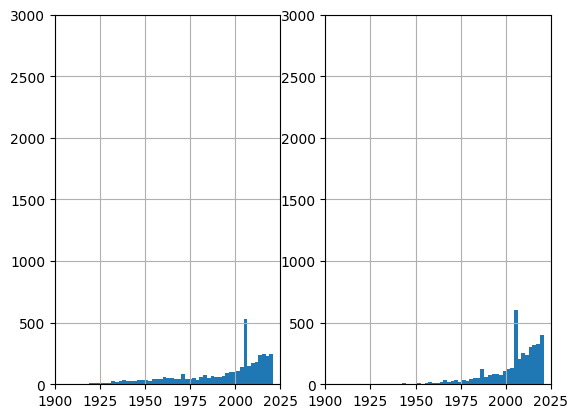

In [4]:
## EDA ##
# Data Import & Preprocessing
train_df = import_train_csvs()
train_df = preprocess_train(train_df)

# Visualize Distribution of Numeric Columns by Label Type
plt.subplot(1,2, 1)
ax = train_df[(train_df['releaseDate'] < 500000) & (train_df['label'] == 1)]['releaseDate'].hist(bins=50)
plt.xlim((1900, 2025))
plt.ylim((0,3000))

plt.subplot(1,2, 2)
train_df[(train_df['releaseDate'] < 500000) & (train_df['label'] == 0)]['releaseDate'].hist(bins=50)
plt.xlim((1900, 2025))
plt.ylim((0,3000))
plt.show()


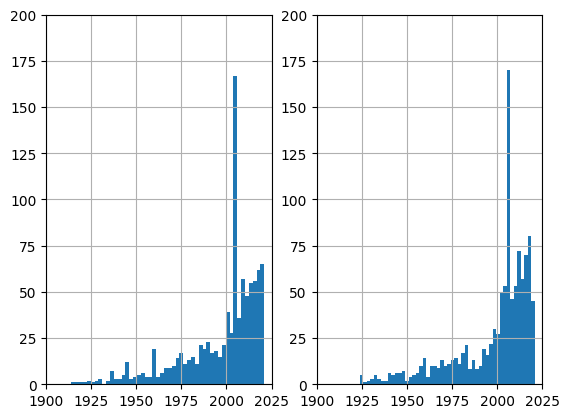

In [5]:
validation_df = import_hidden_csv('validation_hidden.csv')
validation_df = preprocess_hidden(df=validation_df, 
                                  mean_num_votes=train_df['numVotes'].median(),
                                  mean_release_date=train_df['releaseDate'].median(),
                                  mean_runtime_minutes=train_df['runtimeMinutes'].mean())

test_df = import_hidden_csv('test_hidden.csv')
test_df = preprocess_hidden(df=test_df,
                            mean_num_votes=train_df['numVotes'].median(),
                            mean_release_date=train_df['releaseDate'].median(),
                            mean_runtime_minutes=train_df['runtimeMinutes'].mean())

plt.subplot(1,2, 1)
validation_df['releaseDate'].hist(bins=50)
plt.xlim((1900, 2025))
plt.ylim((0,200))

plt.subplot(1,2,2)
test_df['releaseDate'].hist(bins=50)
plt.xlim((1900, 2025))
plt.ylim((0,200))
plt.show()

In [6]:
## Create Count of Directors and Writers for each Movie ##
# Import Datasets
train_df = import_train_csvs()
directors_df = import_directors()
writers_df = import_writers()

/var/folders/pv/ng4pj3dx1lzdf21rlczf5b900000gn/T/ipykernel_21281/4092653553.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_df = pd.concat([train_df, auxilliary_df])


In [7]:
# Count the number of directors per movie
directors_per_movie = directors_df.groupby('movie_id')['director_id'].nunique().reset_index(name='num_directors')

# Count the number of writers per movie
writers_per_movie = writers_df.groupby('movie_id')['writer_id'].nunique().reset_index(name='num_writers')

In [8]:
# Merge director counts and writer counts with train_df
train_df = train_df.merge(directors_per_movie, on='movie_id', how='left')
train_df = train_df.merge(writers_per_movie, on='movie_id', how='left')

train_df = preprocess_train(train_df)
train_df

,movie_id,primaryTitle,originalTitle,runtimeMinutes,numVotes,label,num_directors,num_writers,releaseDate
0,tt0010600,The Doll,Die Puppe,66,1898.0,1,1,4,1919
1,tt0011841,Way Down East,Way Down East,145,5376.0,1,1,5,1920
2,tt0012494,Déstiny,Der müde Tod,97,5842.0,1,1,2,1921
3,tt0015163,The Navigator,The Navigator,59,9652.0,1,2,3,1924
4,tt0016220,The Phantom of the Opera,The Phantom of the Opera,93,17887.0,1,4,9,1925
...,...,...,...,...,...,...,...,...,...
7954,tt9625664,Trauma Center,NaN,87,12951.0,0,1,1,2019
7955,tt9741310,Slaxx,Slaxx,77,2464.0,0,1,2,2020
7956,tt9742392,Kindred,Kindred,101,1719.0,0,1,2,2020
7957,tt9850386,The Bee Gees: How Can You Mend a Broken Heart,NaN,111,4144.0,1,1,1,2020


In [11]:
### XGBoost Algorithm ###
# Selecting X and y from train_df
X = train_df.drop(columns=['movie_id', 'primaryTitle', 'originalTitle', 'label'])
y = train_df['label']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the XGBoost classifier
xgb_model = xgb.XGBClassifier()

# Define hyperparameters grid for tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3]
}

# Perform GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=10, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

# Instantiate XGBoost with the best parameters
best_xgb_model = xgb.XGBClassifier(**best_params)

# Train the model with the best parameters
best_xgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred = best_xgb_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7374371859296482
